
# 🌊 Tsunami Risk Prediction — Compact Notebook


## 1) Setup

In [11]:

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             RocCurveDisplay, ConfusionMatrixDisplay, average_precision_score,
                             precision_recall_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
import joblib, time, json, warnings
warnings.filterwarnings("ignore")
RANDOM_STATE = 42; np.random.seed(RANDOM_STATE)
DATA_PATH = Path("earthquake_data_tsunami.csv")
assert DATA_PATH.exists(), "Dataset not found"


## 2) Load data & quick peek

In [12]:

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
display(df.head(8))
print("\nMissing values per column:")
print(df.isna().sum())


Shape: (782, 13)


,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami
0,7.0,8,7,768,117,0.509,17.0,14.000,-9.7963,159.5960,2022,11,1
1,6.9,4,4,735,99,2.229,34.0,25.000,-4.9559,100.7380,2022,11,0
2,7.0,3,3,755,147,3.125,18.0,579.000,-20.0508,-178.3460,2022,11,1
3,7.3,5,5,833,149,1.865,21.0,37.000,-19.2918,-172.1290,2022,11,1
4,6.6,0,2,670,131,4.998,27.0,624.464,-25.5948,178.2780,2022,11,1
5,7.0,4,3,755,142,4.578,26.0,660.000,-26.0442,178.3810,2022,11,1
6,6.8,1,3,711,136,4.678,22.0,630.379,-25.9678,178.3630,2022,11,1
7,6.7,7,6,797,145,1.151,37.0,20.000,7.6712,-82.3396,2022,10,1



Missing values per column:
magnitude    0
cdi          0
mmi          0
sig          0
nst          0
dmin         0
gap          0
depth        0
latitude     0
longitude    0
Year         0
Month        0
tsunami      0
dtype: int64


## 3) Minimal EDA

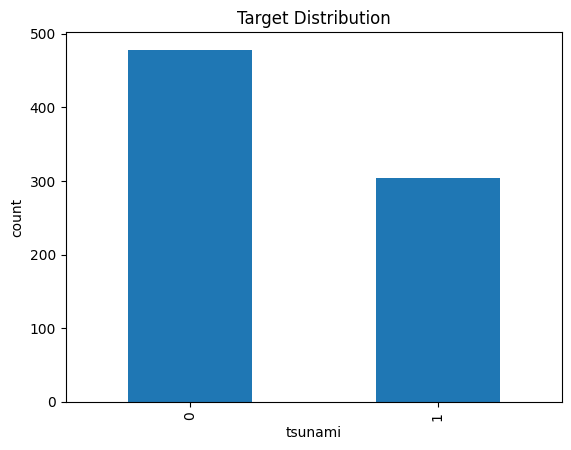

In [13]:

counts = df['tsunami'].value_counts().sort_index()
plt.figure(); counts.plot(kind='bar'); plt.title("Target Distribution"); plt.xlabel("tsunami"); plt.ylabel("count"); plt.show()


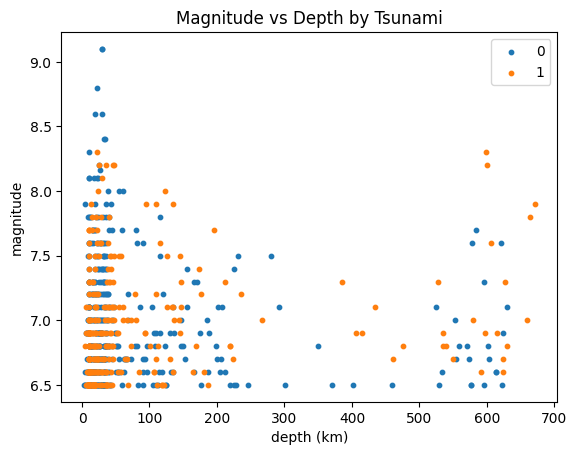

In [14]:

plt.figure()
m1 = df['tsunami']==1
m0 = ~m1
plt.scatter(df.loc[m0,'depth'], df.loc[m0,'magnitude'], s=10, label='0')
plt.scatter(df.loc[m1,'depth'], df.loc[m1,'magnitude'], s=10, label='1')
plt.xlabel("depth (km)"); plt.ylabel("magnitude"); plt.title("Magnitude vs Depth by Tsunami"); plt.legend(); plt.show()


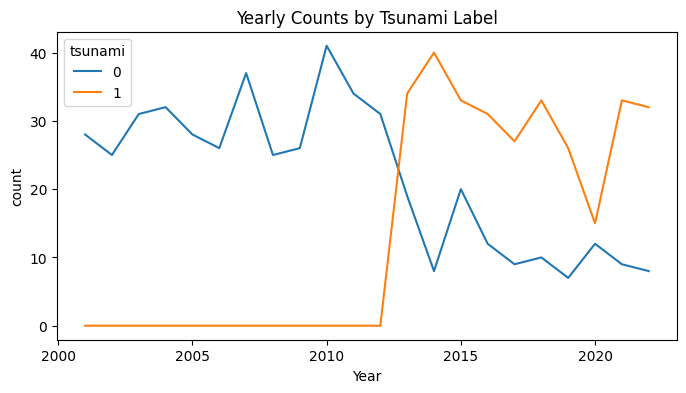

In [15]:

yc = df.groupby(['Year','tsunami']).size().unstack(fill_value=0)
ax = yc.plot(kind='line', figsize=(8,4)); plt.title("Yearly Counts by Tsunami Label"); plt.xlabel("Year"); plt.ylabel("count"); plt.show()


## 4) Feature engineering

In [16]:

df_fe = df.copy()
df_fe['log10_energy'] = 1.5 * df_fe['magnitude'] + 4.8
df_fe['shallow_quake'] = (df_fe['depth'] < 70).astype(int)
yearly_avg_mag = df_fe.groupby('Year')['magnitude'].mean().rename('yearly_avg_magnitude')
df_fe = df_fe.merge(yearly_avg_mag, on='Year', how='left')

target_col = 'tsunami'
feature_cols = [c for c in df_fe.columns if c not in [target_col, 'energy']]
numeric_features = feature_cols
preprocess = ColumnTransformer([('num', Pipeline([('scaler', StandardScaler())]), numeric_features)], remainder='drop')

X = df_fe[feature_cols]; y = df_fe[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (625, 15) Test: (157, 15)


## 5) Baseline models (LogReg & RandomForest)

In [17]:

models = {
    "LogReg": LogisticRegression(max_iter=300, class_weight='balanced', random_state=RANDOM_STATE),
    "RF": RandomForestClassifier(n_estimators=400, class_weight='balanced', random_state=RANDOM_STATE)
}
results = {}
for name, clf in models.items():
    pipe = Pipeline([('prep', preprocess), ('clf', clf)])
    pipe.fit(X_train, y_train)
    y_proba = pipe.predict_proba(X_test)[:,1] if hasattr(pipe, "predict_proba") else None
    y_pred  = pipe.predict(X_test)
    roc = roc_auc_score(y_test, y_proba) if y_proba is not None else float('nan')
    ap  = average_precision_score(y_test, y_proba) if y_proba is not None else float('nan')
    results[name] = {"pipe": pipe, "roc": roc, "ap": ap}
    print(f"=== {name} ==="); print("ROC-AUC:", roc, "PR-AUC:", ap); print(classification_report(y_test, y_pred))


=== LogReg ===
ROC-AUC: 0.9199112021857923 PR-AUC: 0.835465091565207
              precision    recall  f1-score   support

           0       0.96      0.82      0.89        96
           1       0.77      0.95      0.85        61

    accuracy                           0.87       157
   macro avg       0.87      0.89      0.87       157
weighted avg       0.89      0.87      0.87       157

=== RF ===
ROC-AUC: 0.9643101092896175 PR-AUC: 0.9155573327383888
              precision    recall  f1-score   support

           0       0.99      0.91      0.95        96
           1       0.87      0.98      0.92        61

    accuracy                           0.94       157
   macro avg       0.93      0.94      0.93       157
weighted avg       0.94      0.94      0.94       157



## 6) Calibrate best model + cost-sensitive threshold

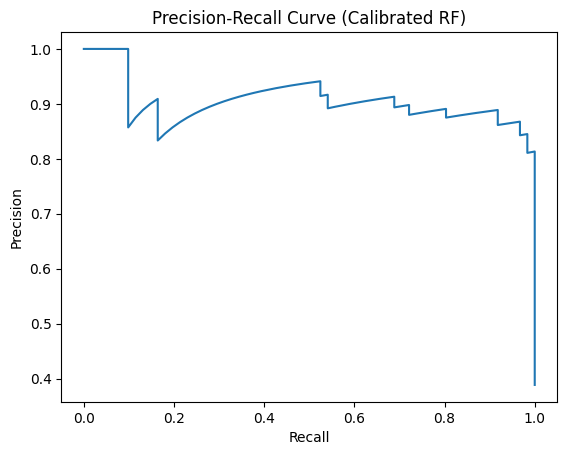

Best model: RF
Calibrated PR-AUC: 0.9059734099116024
Cost-sensitive best threshold: 0.23 Cost: 14.0


<Figure size 640x480 with 0 Axes>

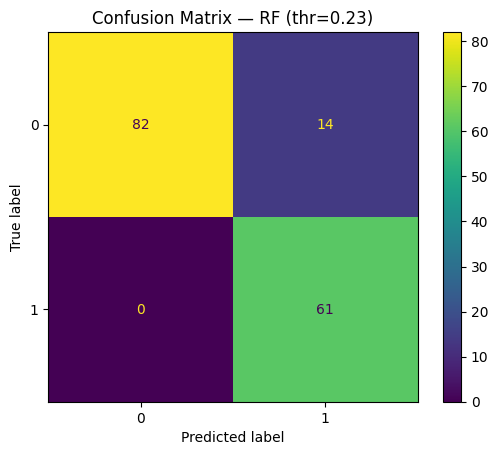

In [18]:

best_name = sorted(results.items(), key=lambda kv: (np.nan_to_num(kv[1]['ap']), np.nan_to_num(kv[1]['roc'])), reverse=True)[0][0]
best_pipe = results[best_name]['pipe']

cal = CalibratedClassifierCV(best_pipe, method='sigmoid', cv=3)
cal.fit(X_train, y_train)
y_proba_cal = cal.predict_proba(X_test)[:,1]

prec, rec, thr = precision_recall_curve(y_test, y_proba_cal)
plt.figure(); plt.plot(rec, prec); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"Precision-Recall Curve (Calibrated {best_name})"); plt.show()

C_FN, C_FP = 10.0, 1.0
def expected_cost(threshold, y_true, y_prob):
    y_hat = (y_prob >= threshold).astype(int)
    FN = ((y_true==1) & (y_hat==0)).sum()
    FP = ((y_true==0) & (y_hat==1)).sum()
    return C_FN*FN + C_FP*FP

best_t, best_cost = 0.5, float('inf')
for t in [i/100 for i in range(1,100)]:
    c = expected_cost(t, y_test.values, y_proba_cal)
    if c < best_cost:
        best_t, best_cost = t, c

print("Best model:", best_name)
print("Calibrated PR-AUC:", average_precision_score(y_test, y_proba_cal))
print("Cost-sensitive best threshold:", best_t, "Cost:", best_cost)

y_pred_t = (y_proba_cal >= best_t).astype(int)
cm = confusion_matrix(y_test, y_pred_t)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(); disp.plot(); plt.title(f"Confusion Matrix — {best_name} (thr={best_t:.2f})"); plt.show()


## 7) Time-based split (optional)

In [19]:

years = sorted(df_fe['Year'].unique())
if len(years) >= 2:
    train_years = years[:-1]; test_years = [years[-1]]
    X_train_t = df_fe[df_fe['Year'].isin(train_years)][feature_cols]
    y_train_t = df_fe[df_fe['Year'].isin(train_years)][target_col]
    X_test_t  = df_fe[df_fe['Year'].isin(test_years)][feature_cols]
    y_test_t  = df_fe[df_fe['Year'].isin(test_years)][target_col]

    cal_tb = CalibratedClassifierCV(best_pipe, method='sigmoid', cv=3)
    cal_tb.fit(X_train_t, y_train_t)
    y_proba_tb = cal_tb.predict_proba(X_test_t)[:,1]
    print("Time-based ROC-AUC:", roc_auc_score(y_test_t, y_proba_tb))
    print("Time-based PR-AUC:", average_precision_score(y_test_t, y_proba_tb))
else:
    print("Only one unique year; skipped time-based split.")


Time-based ROC-AUC: 0.890625
Time-based PR-AUC: 0.9544043881849664


## 8) Save calibrated bundle + inference helper

In [21]:

bundle = {
    "model": cal,
    "meta": {
        "name": f"Calibrated{best_name}",
        "created_at": time.strftime("%Y-%m-%d %H:%M:%S"),
        "best_threshold": float(best_t),
        "features": [c for c in feature_cols],
        "notes": "Calibrated classifier with tuned threshold; includes log10_energy, shallow_quake, yearly_avg_magnitude."
    }
}
outp = Path("tsunami_best_model.pkl")
joblib.dump(bundle, outp); print("Saved:", outp)

def fe_for_inference(df_row: pd.DataFrame, ref_df: pd.DataFrame) -> pd.DataFrame:
    ref_map = ref_df.groupby('Year')['magnitude'].mean().to_dict()
    gmean = float(ref_df['magnitude'].mean())
    row = df_row.copy()
    row['log10_energy'] = 1.5 * row['magnitude'] + 4.8
    row['shallow_quake'] = (row['depth'] < 70).astype(int)
    row['yearly_avg_magnitude'] = row['Year'].map(ref_map).fillna(gmean)
    return row

def predict_tsunami(sample_kwargs: dict) -> dict:
    row = pd.DataFrame([sample_kwargs])
    row_fe = fe_for_inference(row, df_fe)
    prob = float(cal.predict_proba(row_fe)[:,1][0])
    pred = int(prob >= bundle['meta']['best_threshold'])
    return {"pred": pred, "prob": prob, "threshold": bundle['meta']['best_threshold']}

predict_tsunami({
    "magnitude": 6.8, "depth": 20.0, "cdi": 5, "mmi": 6, "sig": 650, "nst": 100, "dmin": 0.7, "gap": 55,
    "latitude": -3.0, "longitude": 135.0, "Year": 2022, "Month": 11
})


Saved: tsunami_best_model.pkl


{'pred': 1, 'prob': 0.8128195794537777, 'threshold': 0.23}